In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [3]:
fake = pd.read_csv(r'D:\Fake-news-detection\fake.csv')

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

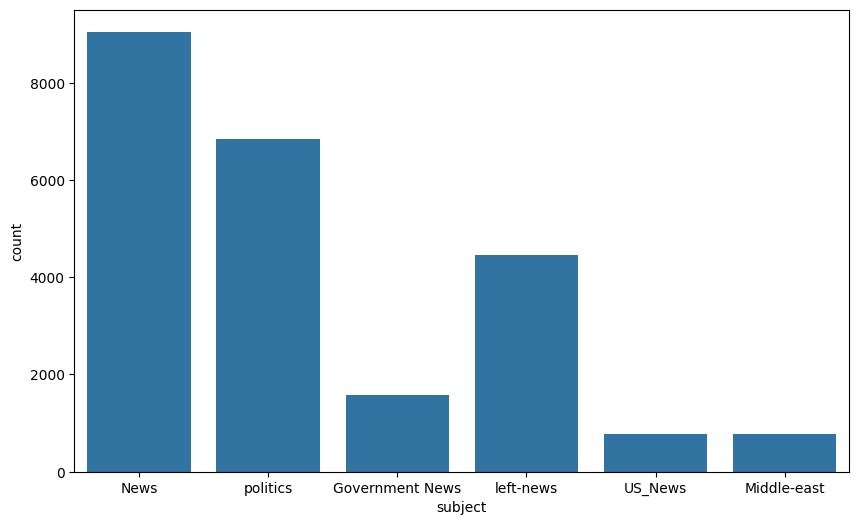

In [7]:

plt.figure(figsize=(10,6))
sns.countplot(x='subject', data=fake)   # use x= instead of passing series directly
plt.show()


In [8]:
text = ' '.join(fake['text'].tolist())

In [9]:
' '.join(['this', 'is', 'a', 'data'])

'this is a data'

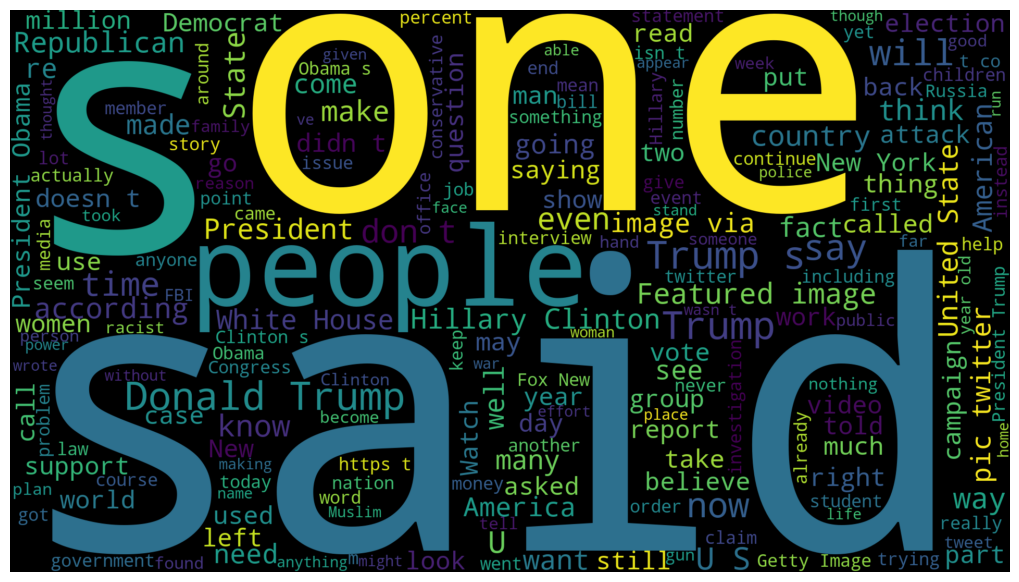

In [10]:
wordCloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordCloud, interpolation='bilinear') 
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
real = pd.read_csv(r'D:\Fake-news-detection\true.csv')

In [12]:
text = ' '.join(real['text'].tolist())

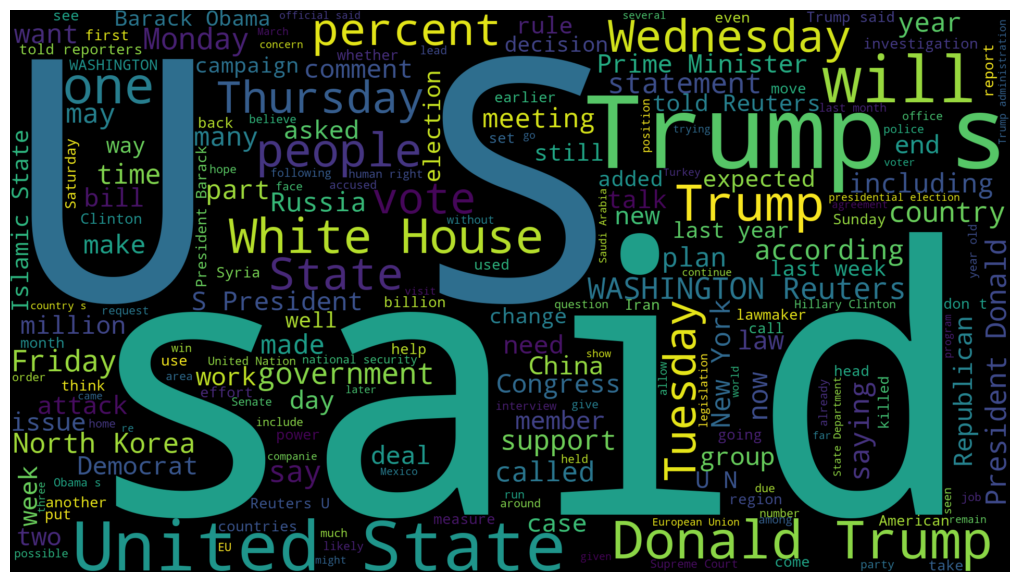

In [13]:
wordCloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [14]:
real.sample(5)

,title,text,subject,date
1873,"Trump, lawmakers agree on disaster aid, debt l...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 6, 2017"
8636,Trump says he would consider alliance with Rus...,"WINSTON-SALEM, N.C. (Reuters) - Republican nom...",politicsNews,"July 25, 2016"
20233,Average of polls puts New Zealand's ruling Nat...,WELLINGTON (Reuters) - New Zealand s ruling Na...,worldnews,"September 13, 2017"
20089,"London fire inquiry starts amid anger, despair...",LONDON (Reuters) - A public inquiry into a fir...,worldnews,"September 14, 2017"
20999,China and India are development opportunities ...,BEIJING (Reuters) - Chinese President Xi Jinpi...,worldnews,"September 5, 2017"


In [15]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try: 
        record = row.split('-',maxsplit=1)
        record[1]
        assert (len(record[0]) < 120)

    except:
        unknown_publishers.append(index)

In [16]:
len(unknown_publishers)

222

In [17]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [18]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [19]:
real = real.drop(8970, axis=0)

In [20]:
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('unknown')
    else:
        record = row.split('-',maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [21]:
real['publisher'] = publisher
real['text'] = tmp_text

In [22]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [23]:
real.shape

(21416, 5)

In [24]:
empty_fake_index =[index for index, text in enumerate(fake.text.tolist()) if str(text).strip()=='']


In [25]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [26]:
real['text'] = real['title'] + ' ' + real['text']
fake['text'] = fake['title'] + ' ' + fake['text']

In [27]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

In [28]:
real['class'] = 1
fake['class'] = 0

In [29]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [30]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [31]:
data = pd.concat([real, fake], ignore_index=True)

In [32]:
data.sample(5)

,text,class
40973,cnn’s wolf blitzer gets a tongue lashing from ...,0
38198,fox news biggie promoting mass immigration to ...,0
39889,conservatives who disrupted trump assassinatio...,0
18543,trump to top u.s. diplomat: don't bother talki...,1
10747,republican jeb bush ends 2016 presidential cam...,1


In [33]:
#code to remove special characters 
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'  # Pattern to match non-alphanumeric characters
    cleaned_text = re.sub(pattern, '', text)  # Remove special characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra spaces
    return cleaned_text


In [34]:
data['text'] = data['text'].apply(remove_special_characters)

In [35]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [36]:
import gensim
y = data['class'].values
X = [d.split()for d in data['text'].tolist()]


In [37]:
type(X[0])

list

In [38]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [39]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [40]:
len(w2v_model.wv.key_to_index)


230760

In [41]:
w2v_model.wv.most_similar('trump')

[('trumps', 0.7318165302276611),
 ('trumpit', 0.5845382809638977),
 ('trumpthe', 0.5814315676689148),
 ('he', 0.5544607639312744),
 ('presidentelect', 0.5337857007980347),
 ('cruz', 0.5319229960441589),
 ('him', 0.5207054615020752),
 ('trumptrump', 0.5206249952316284),
 ('rumsfeld', 0.5140334367752075),
 ('suspectironically', 0.5113992691040039)]

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [43]:
X = tokenizer.texts_to_sequences(X)

In [44]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

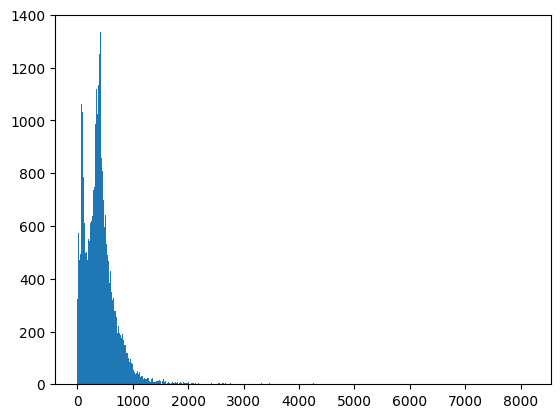

In [45]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [46]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1584

In [47]:
maxlen = 1000
X = pad_sequences(X, maxlen= maxlen)

In [48]:
len(X[101])

1000

In [49]:
vocab_size = len(tokenizer.word_index)+1
vocab = tokenizer.word_index

In [50]:
def get_weight_matrix (model):
    weight_matrix = np.zeros((vocab_size, DIM))
    for word, i in vocab.items():
        weight_matrix[i]= model.wv[word]
    return weight_matrix
    

In [51]:
embedding_vectors = get_weight_matrix(w2v_model)

In [52]:
embedding_vectors.shape

(230761, 100)

In [53]:
model=  Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights= [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.build(input_shape=(None, maxlen))

d:\Fake-news-detection\fakenews_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │    23,076,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,193,477 (88.48 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 23,076,100 (88.03 MB)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [56]:
import numpy as np

# Save test data for later use in Streamlit dashboard
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)


In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 981s 1s/step - acc: 0.9342 - loss: 0.1670 - val_acc: 0.9756 - val_loss: 0.0738
Epoch 2/6
510/737 ━━━━━━━━━━━━━━━━━━━━ 3:54 1s/step - acc: 0.9720 - loss: 0.0804

In [ ]:
y_pred = (model.predict(X_test)>=0.5).astype(int)

351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 402ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9948329621380846

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5849
           1       0.99      1.00      0.99      5376

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
# Save model
model.save("fake_news_model.h5")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
